In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


class SimpleMLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.fc_in = nn.Linear(in_features=4, out_features=5)
        self.fc2 = nn.Linear(in_features=5, out_features=7)
        self.fc_out = nn.Linear(in_features=7, out_features=n_classes)

    def forward(self, x, get_features=False):
        x = self.fc_in(x)
        x = F.relu(x)
        x = self.fc2(x)
        y = F.relu(x)
        x = self.fc_out(y)
        x = F.softmax(x, dim=1)
        if get_features:
            return x, y
        return x


def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    log_writer=None,
    verbose=True,
):

    history = {
        "train": {"loss": [], "accuracy": []},
        "valid": {"loss": [], "accuracy": []},
    }
    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = 0
        total = 0
        evaluation_train = {"accuracy": 0, "loss": 0}
        for idx, data in enumerate(tqdm(train_loader,disable=not verbose)):
            input, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)
            correct += accuracy(output, labels) * len(labels)
            total += len(labels)
        # Loss_history.append(Loss_epoch/n)
        evaluation_train["accuracy"] = correct / total
        evaluation_train["loss"] = Loss_epoch / total
        # evaluation_train = evaluate(model, train_loader,criterion, device)
        evaluation_valid, *_ = evaluate(model, valid_loader, criterion, device)
        if verbose:
            print(f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}")

        history["train"]["accuracy"].append(evaluation_train["accuracy"])
        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])
        history["valid"]["accuracy"].append(evaluation_valid["accuracy"])

        if log_writer is not None:
            log_writer.log(
                {
                    "train/train_loss": (evaluation_train["loss"],epoch),
                    "train/train_accuracy": (evaluation_train["accuracy"],epoch),
                    "val/valid_loss": (evaluation_valid["loss"],epoch),
                    "val/valid_accuracy": (evaluation_valid["accuracy"],epoch),
                }
            )

    return history


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()


def evaluate(model, data_loader, criterion, device, return_preds=False,return_features=False):
    model.eval()
    Accuracy_history = []
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target)
            Accuracy_history.append(accuracy(output, target))
            Loss_history.append(loss.item())
            if return_preds:
                # PREDS.extend(torch.max(output, dim=1)[1].tolist())
                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return {
        "accuracy": torch.mean(torch.Tensor(Accuracy_history)).item(),
        "loss": torch.mean(torch.Tensor(Loss_history)).item(),
    }, PREDS , features , ground_truth

In [20]:
from torchvision.datasets import DatasetFolder, ImageFolder
from skimage import color

from torchvision.transforms import v2 as tt
# class HymenopteraDataset(ImageFolder):
#     def __init__(self, data_path, transform=None):
#         super().__init__(data_path, transform)
#         # self.data_path = data_path  # torch.Tensor(x,).unsqueeze(1).type(torch.FloatTensor)
#         # self.dataset =  self.make_dataset(self.data_path)                        # torch.Tensor(y).type(torch.LongTensor)
#         # self.transform = transform
#         self.rgb_transforms = tt.Compose([tt.Resize((224,224))])
#     # def __getitem__(self, idx):
#     #     rgb_image , y = super().__getitem__(idx)
#     #     # rgb_image = self.dataset[idx][0]
#     #     # y = self.dataset[idx][1]
#     #     processed_rgb_image = self.rgb_transforms(rgb_image)
#     #     lab_image = color.rgb2lab(tt.ToPILImage()(processed_rgb_image))

#     #     if self.transform:
#     #         processed_lab = self.transform(lab_image)
#     #     return processed_rgb_image, processed_lab 

#     # def __len__(self):
#     #     return )

In [40]:


dataset_train  = ImageFolder("./hymenoptera_data/train", transform= tt.Compose([tt.ToTensor]))
dataset_valid  = ImageFolder(root="./hymenoptera_data/val")

In [41]:
from torch.utils.data import Dataset, DataLoader
loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [42]:
next(iter(loader))

TypeError: __init__() takes 1 positional argument but 2 were given

In [16]:
r,y = next(iter(loader))

TypeError: __init__() takes 1 positional argument but 2 were given

In [17]:
r

NameError: name 'r' is not defined

In [18]:
import matplotlib.pyplot as plt
plt.imshow(tt.ToPILImage()(r[0]))

NameError: name 'r' is not defined

In [19]:
(r[0])

NameError: name 'r' is not defined

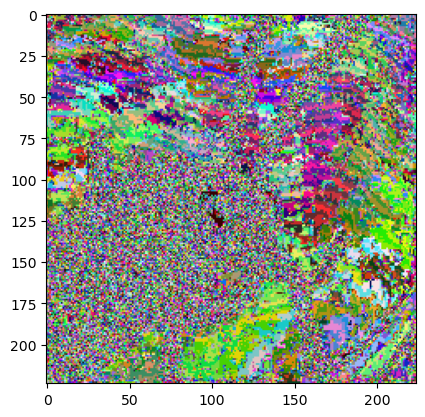

In [120]:
plt.imshow(tt.ToPILImage()(l[0]))

In [102]:
import numpy as np
color.rgb2lab(tt.ToPILImage()(np.array([[0.0,0.0,255.0]],dtype=np.float32)/255.0))

array([[  32.295673,   79.18558 , -107.8573  ]], dtype=float32)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as tt
from sklearn.model_selection import train_test_split


class IRISDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x  # torch.Tensor(x,).unsqueeze(1).type(torch.FloatTensor)
        self.y = y  # torch.Tensor(y).type(torch.LongTensor)
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)